# Step 1: Predict the Market Movement
- Bull Market (State 0): In the following quarter, most of weekly returns are positive.
- Bear Market (State 1): In the following quarter, most of weekly returns are negative.

In [1]:
#Download S&P 500 index dataset from yahoo finance

#!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np

ticker = "^GSPC"
start_date = '1949-1-1' 
end_date = '2022-2-28'

df = yf.download(ticker, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1949-01-03,14.95,14.95,14.95,14.95,14.95,0
1949-01-04,15.03,15.03,15.03,15.03,15.03,0
1949-01-05,15.16,15.16,15.16,15.16,15.16,0
1949-01-06,15.50,15.50,15.50,15.50,15.50,0
1949-01-07,15.61,15.61,15.61,15.61,15.61,0


## 1.1 Preapre Target Data: Label Market Regimes 

In [2]:
# Calculate daily return
df['return_d'] = df['Adj Close']/df['Adj Close'].shift(1) -1
#df['futreturn_d'] = df['Adj Close'].shift(-1)/df['Adj Close'] -1 # Delete

# Calcuate future return in following week for each day
period_len = 5
col_name = 'futreturn_' + str(period_len)
df[col_name] = df['Adj Close'].shift(-period_len)/df['Adj Close'] -1

df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,return_d,futreturn_5
Date,,,,,,,,
1949-01-04,15.03,15.03,15.03,15.03,15.03,0,0.005351,0.031271
1949-01-05,15.16,15.16,15.16,15.16,15.16,0,0.008649,0.020449
1949-01-06,15.50,15.50,15.50,15.50,15.50,0,0.022427,-0.007097
1949-01-07,15.61,15.61,15.61,15.61,15.61,0,0.007097,-0.023703
1949-01-10,15.51,15.51,15.51,15.51,15.51,0,-0.006406,-0.008382


In [3]:
# Label positive (1) or negative (0) return for each day
df = df.copy()
df.loc[ (df[col_name] < 0) , "PorN"] = 1
df.loc[ (df[col_name] >= 0), "PorN"] = 0

df.head()

,Open,High,Low,Close,Adj Close,Volume,return_d,futreturn_5,PorN
Date,,,,,,,,,
1949-01-04,15.03,15.03,15.03,15.03,15.03,0,0.005351,0.031271,0.0
1949-01-05,15.16,15.16,15.16,15.16,15.16,0,0.008649,0.020449,0.0
1949-01-06,15.50,15.50,15.50,15.50,15.50,0,0.022427,-0.007097,1.0
1949-01-07,15.61,15.61,15.61,15.61,15.61,0,0.007097,-0.023703,1.0
1949-01-10,15.51,15.51,15.51,15.51,15.51,0,-0.006406,-0.008382,1.0


In [4]:
# Label state for each day
#!pip install spicy
from scipy.stats import mode
df['new_state'] = df.PorN.shift(-63).rolling(63).apply(lambda x: mode(x)[0])

df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,return_d,futreturn_5,PorN,new_state
Date,,,,,,,,,,
1949-04-01,14.94,14.94,14.94,14.94,14.94,0,-0.007968,0.002008,0.0,1.0
1949-04-04,14.98,14.98,14.98,14.98,14.98,0,0.002677,0.000668,0.0,1.0
1949-04-05,14.96,14.96,14.96,14.96,14.96,0,-0.001335,0.004679,0.0,1.0
1949-04-06,14.92,14.92,14.92,14.92,14.92,0,-0.002674,0.006702,0.0,1.0
1949-04-07,14.93,14.93,14.93,14.93,14.93,0,0.000670,0.004019,0.0,1.0


<AxesSubplot:>

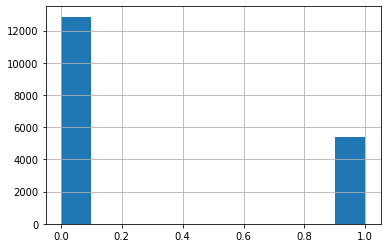

In [5]:
# Visualize labels of new_state 
#!pip install matplotlib
import matplotlib.pyplot as plt
df.new_state.hist()

## 1.2 Prepare Features

- 1. Past (2 weeks/ 1 month/ 1 quarter/ half year/ 1 year) Return
- 2. Past (2 weeks/ 1 month/ 1 quarter/ half year/ 1 year) Volatility
- 3. Multiple Technical Indicators (MACD/ RSI/ OBV/ ADI/ Force Index)

In [6]:
# 1. Return
df = df.copy()
df['return_10'] = df['Adj Close'] / df['Adj Close'].shift(10) -1
df['return_21'] = df['Adj Close'] / df['Adj Close'].shift(21) -1
df['return_63'] = df['Adj Close'] / df['Adj Close'].shift(63) -1
df['return_126'] = df['Adj Close'] / df['Adj Close'].shift(126) -1
df['return_252'] = df['Adj Close'] / df['Adj Close'].shift(252) -1


# 2. Volatility
df['vol_10'] = df['return_d'].rolling(10).std()
df['vol_21'] = df['return_d'].rolling(21).std()
df['vol_63'] = df['return_d'].rolling(63).std()
df['vol_126'] = df['return_d'].rolling(126).std()
df['vol_252'] = df['return_d'].rolling(252).std()

df.head()

,Open,High,Low,Close,Adj Close,Volume,return_d,futreturn_5,PorN,new_state,return_10,return_21,return_63,return_126,return_252,vol_10,vol_21,vol_63,vol_126,vol_252
Date,,,,,,,,,,,,,,,,,,,,
1949-04-01,14.94,14.94,14.94,14.94,14.94,0,-0.007968,0.002008,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-04,14.98,14.98,14.98,14.98,14.98,0,0.002677,0.000668,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-05,14.96,14.96,14.96,14.96,14.96,0,-0.001335,0.004679,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-06,14.92,14.92,14.92,14.92,14.92,0,-0.002674,0.006702,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-07,14.93,14.93,14.93,14.93,14.93,0,0.000670,0.004019,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 3. Multiple Technical Indicators
#!pip install ta
import ta

# MACD
df["MACD_10_21"] = ta.trend.macd(df['Adj Close'], window_fast = 10, window_slow=21)
df["MACD_21_63"] = ta.trend.macd(df['Adj Close'], window_fast = 21, window_slow=63)
df["MACD_63_126"] = ta.trend.macd(df['Adj Close'], window_fast = 63, window_slow=126)
df["MACD_126_252"] = ta.trend.macd(df['Adj Close'], window_fast = 126, window_slow=252)

# RSI
df["RSI_10"] = ta.momentum.rsi(df['Adj Close'], window=10)
df["RSI_21"] = ta.momentum.rsi(df['Adj Close'], window=21)
df["RSI_63"] = ta.momentum.rsi(df['Adj Close'], window=63)
df["RSI_126"] = ta.momentum.rsi(df['Adj Close'], window=126)
df["RSI_252"] = ta.momentum.rsi(df['Adj Close'], window=252)

# OBV
df["OBV"] = ta.volume.volume_price_trend(df['Adj Close'], volume = df['Volume'])

# ADI
df["ADI"] = ta.volume.acc_dist_index(high = df['High'], low = df['Low'], close = df['Adj Close'], volume = df['Volume'] )

# Force Index
df["FI_10"] = ta.volume.force_index(close = df['Adj Close'], volume = df['Volume'], window=10)
df["FI_21"] = ta.volume.force_index(close = df['Adj Close'], volume = df['Volume'], window=21)
df["FI_63"] = ta.volume.force_index(close = df['Adj Close'], volume = df['Volume'], window=63)
df["FI_126"] = ta.volume.force_index(close = df['Adj Close'], volume = df['Volume'], window=126)
df["FI_252"] = ta.volume.force_index(close = df['Adj Close'], volume = df['Volume'], window=252)

df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,return_d,futreturn_5,PorN,new_state,...,RSI_63,RSI_126,RSI_252,OBV,ADI,FI_10,FI_21,FI_63,FI_126,FI_252
Date,,,,,,,,,,,,,,,,,,,,,
1950-04-06,17.780001,17.780001,17.780001,17.780001,17.780001,2000000,0.008508,0.010124,0.0,0.0,...,61.714880,60.123823,59.000859,23535.135730,0.0,86292.806321,49713.406590,25086.783304,15470.146761,8827.012730
1950-04-10,17.850000,17.850000,17.850000,17.850000,17.850000,2070000,0.003937,0.001681,0.0,0.0,...,62.306479,60.468939,59.242682,25166.193600,0.0,96948.544860,58366.675835,28830.926584,17508.402218,9902.683525
1950-04-11,17.750000,17.750000,17.750000,17.750000,17.750000,2010000,-0.005602,0.015775,0.0,0.0,...,60.939535,59.724600,58.745710,-3110.976461,0.0,42775.942748,34787.817418,21648.686168,14067.312943,8235.462574
1950-04-12,17.940001,17.940001,17.940001,17.940001,17.940001,2010000,0.010704,0.006131,0.0,0.0,...,62.526767,60.652224,59.395469,10255.006518,0.0,104435.057422,66343.567967,32906.573270,19859.970589,11189.340921
1950-04-13,17.980000,17.980000,17.980000,17.980000,17.980000,2410000,0.002230,-0.002781,1.0,0.0,...,62.849698,60.843601,59.530190,26888.887149,0.0,102973.703293,69075.753580,34890.668159,21065.287741,11862.924073


## 1.3 Split Train and Test Data
- Train Period: 1950 - 1969
- Test Period: 1970 - 2020

In [8]:
## Split to train and test data
train = df[: '1970/1/1']
test = df['1970/1/1':"2022/1/1"]
print(train.columns)
print(test.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'return_d',
       'futreturn_5', 'PorN', 'new_state', 'return_10', 'return_21',
       'return_63', 'return_126', 'return_252', 'vol_10', 'vol_21', 'vol_63',
       'vol_126', 'vol_252', 'MACD_10_21', 'MACD_21_63', 'MACD_63_126',
       'MACD_126_252', 'RSI_10', 'RSI_21', 'RSI_63', 'RSI_126', 'RSI_252',
       'OBV', 'ADI', 'FI_10', 'FI_21', 'FI_63', 'FI_126', 'FI_252'],
      dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'return_d',
       'futreturn_5', 'PorN', 'new_state', 'return_10', 'return_21',
       'return_63', 'return_126', 'return_252', 'vol_10', 'vol_21', 'vol_63',
       'vol_126', 'vol_252', 'MACD_10_21', 'MACD_21_63', 'MACD_63_126',
       'MACD_126_252', 'RSI_10', 'RSI_21', 'RSI_63', 'RSI_126', 'RSI_252',
       'OBV', 'ADI', 'FI_10', 'FI_21', 'FI_63', 'FI_126', 'FI_252'],
      dtype='object')


In [9]:
X_train = train[['return_10',
       'return_21', 'return_63', 'return_126', 'return_252', 'vol_10',
       'vol_21', 'vol_63', 'vol_126', 'vol_252', 'MACD_10_21', 'MACD_21_63',
       'MACD_63_126', 'MACD_126_252', 'RSI_10', 'RSI_21', 'RSI_63', 'RSI_126',
       'RSI_252', 'OBV', 'ADI', 'FI_10', 'FI_21', 'FI_63', 'FI_126', 'FI_252']]
X_test = test[['return_10',
       'return_21', 'return_63', 'return_126', 'return_252', 'vol_10',
       'vol_21', 'vol_63', 'vol_126', 'vol_252', 'MACD_10_21', 'MACD_21_63',
       'MACD_63_126', 'MACD_126_252', 'RSI_10', 'RSI_21', 'RSI_63', 'RSI_126',
       'RSI_252', 'OBV', 'ADI', 'FI_10', 'FI_21', 'FI_63', 'FI_126', 'FI_252']]
y_train = train['new_state']
y_test = test['new_state']

## 1.4 Scaling Features

In [10]:
#!pip install sklearn
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_temp = X_train.copy()
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train,index=X_train_temp.index,columns=X_train_temp.columns)

X_test_temp = X_test.copy()
X_test = sc.transform(X_test)
X_test = pd.DataFrame(X_test,index=X_test_temp.index,columns=X_test_temp.columns)

## 1.5 Using XGboost to predict the future market movement
- Bull Market (State 0): In the following quarter, most of weekly returns are positive.
- Bear Market (State 1): In the following quarter, most of weekly returns are negative.

In [11]:
# install (if required) and import required packages

# conda install -c conda-forge py-xgboost
import xgboost
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import  classification_report, plot_confusion_matrix

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [12]:
# create XGboostClassifier and fit the training data
# using hyperparameter scale_pos_weight to deal with imbalanced issue
xgb = XGBClassifier(max_depth=2, n_estimators= 10, scale_pos_weight = 2, use_label_encoder=False).fit(X_train, y_train)

[22:24:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([[<AxesSubplot:title={'center':'predstate'}>]], dtype=object)

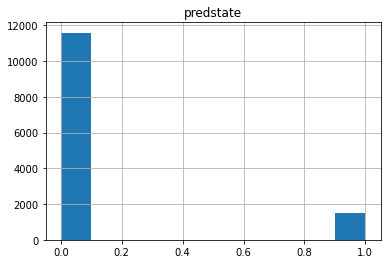

In [13]:
# use XGboost model to predict on testing data
y_pred = xgb.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns = ["predstate"], index = X_test.index)
# visualize the predicted labels
y_pred.hist()

In [14]:
# Print out the statistics of model performance 
target_names = ['state 0', 'state 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     state 0       0.71      0.90      0.79      9058
     state 1       0.42      0.16      0.23      4030

    accuracy                           0.67     13088
   macro avg       0.56      0.53      0.51     13088
weighted avg       0.62      0.67      0.62     13088



/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


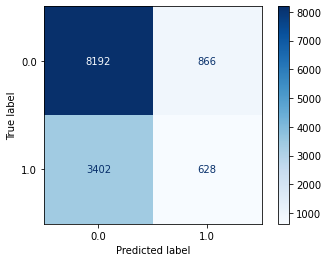

In [15]:
# Visualize model performace by confusion matrix
plot_confusion_matrix(xgb, X_test, y_test, values_format=".4g", cmap="Blues");

## 1.6 Tuning Hyperparameter of XGboost Model

In [16]:
# Using Gridsearch to tune n_estimator, max_depth and scale_pos_weight and recording the result

# from sklearn.model_selection import GridSearchCV
# xgb_v2 = XGBClassifier(max_depth=2, n_estimators= 10, scale_pos_weight = 2, use_label_encoder=False).fit(X_train, y_train)
# parameters = {'n_estimators':[2, 4, 6, 8, 10, 12, 14, 17, 18, 20], 
#               'max_depth': [2, 3, 4, 5],
#               'scale_pos_weight' : [1, 1.5, 1.75, 2, 2.5, 2.75, 3, 3.25, 3.5, 3.75]}
# xgb_v2 = GridSearchCV(xgb_v2, parameters, cv = 5, scoring="roc_auc").fit(X_train, y_train)
# xgb_v2.best_estimator_

## output
## XGBClassifier(max_depth=2, n_estimators=2, scale_pos_weight=1.75,use_label_encoder=False)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:24:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[<AxesSubplot:title={'center':'predstate'}>]], dtype=object)

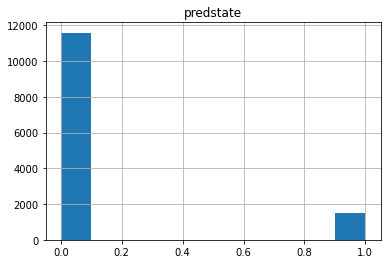

In [17]:
# Fit the XGboost model again
xgb_v2 = XGBClassifier(max_depth=2, n_estimators=2, scale_pos_weight=1.75,use_label_encoder=False).fit(X_train, y_train)
y_pred_v2 = xgb_v2.predict(X_test)
y_pred_v2 = pd.DataFrame(y_pred, columns = ["predstate"], index = X_test.index)
y_pred_v2.hist()

In [18]:
# Print out the statistics of model performance again
target_names = ['state 0', 'state 1']
print(classification_report(y_test, y_pred_v2, target_names=target_names))

              precision    recall  f1-score   support

     state 0       0.71      0.90      0.79      9058
     state 1       0.42      0.16      0.23      4030

    accuracy                           0.67     13088
   macro avg       0.56      0.53      0.51     13088
weighted avg       0.62      0.67      0.62     13088



/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


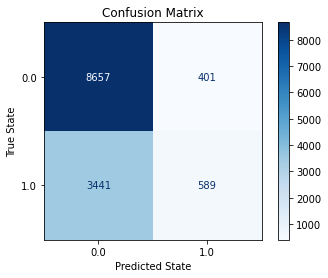

In [19]:
# Visualize model performace by confusion matrix
plot_confusion_matrix(xgb_v2, X_test, y_test, values_format=".4g", cmap="Blues");
plt.title("Confusion Matrix")
plt.grid(visible = False)
plt.xlabel("Predicted State")
plt.ylabel("True State")
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

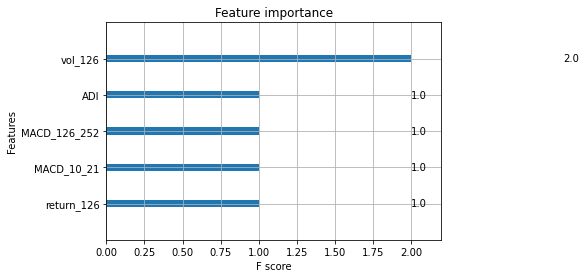

In [20]:
# Using plot_inportance to know the feature importance 
plot_importance(xgb_v2)

## 1.7 Visualize the Predicted Market Movement

In [21]:
test_pred_data = pd.concat([test[['Open', 'High', 'Low', 'Adj Close','return_d', 'new_state']],y_pred_v2],axis=1,sort='False')

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_20170/2302327857.py:1: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  test_pred_data = pd.concat([test[['Open', 'High', 'Low', 'Adj Close','return_d', 'new_state']],y_pred_v2],axis=1,sort='False')


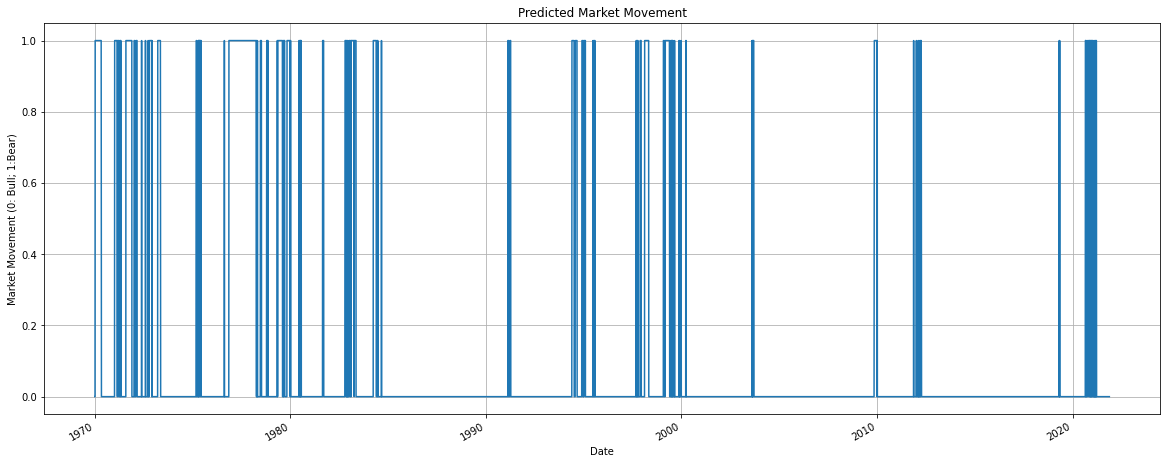

In [22]:
plt.figure(figsize=(20, 8))
test_pred_data.predstate.plot()
plt.title('Predicted Market Movement')
plt.ylabel('Market Movement (0: Bull; 1:Bear)')
plt.grid()
plt.show()

## 1.8 Validate the Classification Results by comapring with Buy and Hold Strategy
- Buy and Hold Strategy: Always Long.
- Strategy with predicted market movement: Long if state 0, short if state 1.  

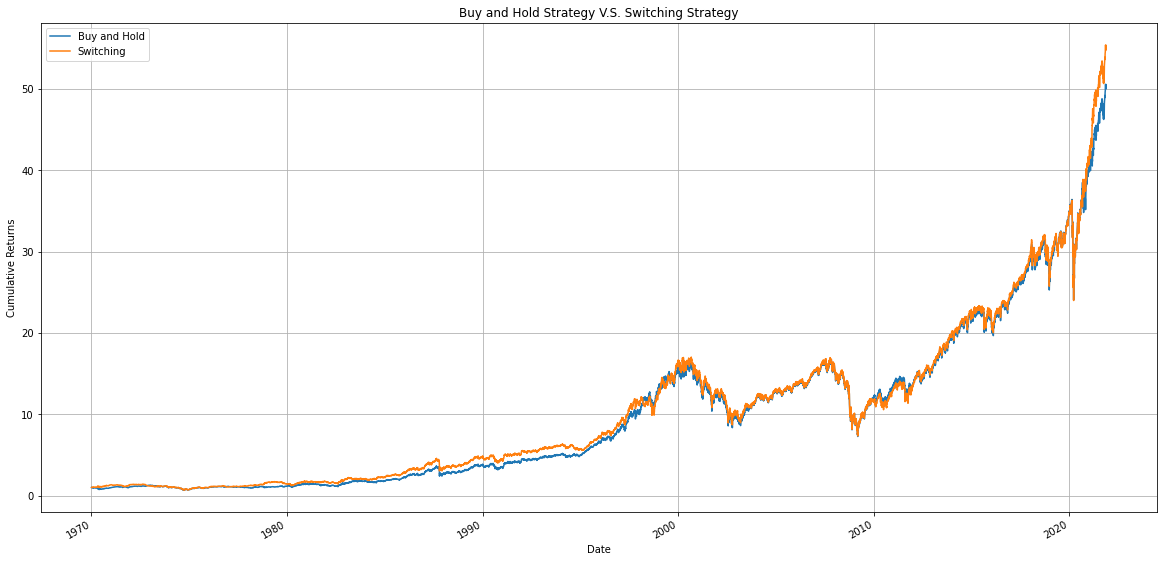

In [23]:
import matplotlib.pyplot as plt

# Calculate buy & hold strategy returns
test_pred_data = test_pred_data.copy()
test_pred_data['BnH_returns'] = test_pred_data.return_d.shift(-1)

# Retrun with predicted market movement
# Calculate the strategy returns
test_pred_data.loc[test_pred_data['predstate'] == 1, 'predstate_returns'] = -1 * test_pred_data.return_d.shift(-1)
test_pred_data.loc[test_pred_data['predstate'] == 0, 'predstate_returns'] = test_pred_data.return_d.shift(-1)
    

    
# Plot the stock strategy and buy and hold returns
plt.figure(figsize=(20, 10))
# Calculate the cumulative buy and hold strategy returns
(test_pred_data.BnH_returns+1).cumprod().plot()
# Calculate the cumulative (predicted )strategy returns and plot
(test_pred_data.predstate_returns+1).cumprod().plot()
plt.title('Buy and Hold Strategy V.S. Switching Strategy')
plt.ylabel('Cumulative Returns')
plt.legend(labels=['Buy and Hold', 'Switching'])
plt.grid(visible = True)
plt.show()

In [24]:
# Culmulative return on 2020/12/31 of Buy and Hold Strategy
(test_pred_data.BnH_returns+1).cumprod()[-2]

50.4158056115593

In [25]:
# Culmulative return on 2020/12/31 of Predicted Market Movement Strategy
(test_pred_data.predstate_returns+1).cumprod()[-2]

55.22972971845168

In [26]:
# How many percentages of transactions earn profits (long while market is going to rise) under Buy and Hold Strategy?
rise = test_pred_data.loc[test_pred_data["BnH_returns"] >= 0]
fall = test_pred_data.loc[test_pred_data["BnH_returns"] < 0]
len(rise)/ (len(rise)+len(fall))

0.5319018873691449

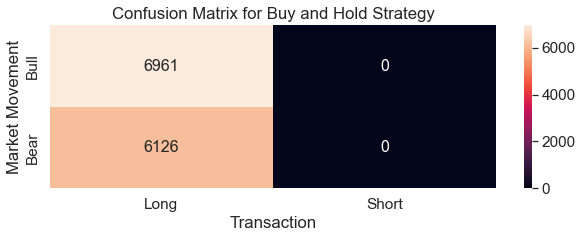

In [27]:
#!pip install seaborn
import seaborn as sn

array = [[len(rise),0],[len(fall),0]]

df_cm = pd.DataFrame(array, ["Bull", "Bear"], ["Long", "Short"])
plt.figure(figsize=(10,3))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.title("Confusion Matrix for Buy and Hold Strategy")
plt.grid(visible = False)
plt.xlabel("Transaction")
plt.ylabel("Market Movement")
plt.show()
plt.show()

In [28]:
# How many percentages of long transactions earn profits (long while market is going to rise) under Predicted Market Movement Strategy?
PM_long_earn = rise.loc[rise["predstate"] == 0]
PM_long_loss = rise.loc[rise["predstate"] == 1]
len(PM_long_earn)/ len(rise)

0.889671024278121

In [29]:
# How many percentages of short transactions earn profits (short while market is going to fall) under Predicted Market Movement Strategy?
PM_short_earn = fall.loc[fall["predstate"] == 1]
PM_short_loss = fall.loc[fall["predstate"] == 0]
len(PM_short_earn)/ len(fall)

0.11851126346718903

In [30]:
# How many percentages of transactions earn profits (short while fall; long while rise) under Predicted Market Movement Strategy?
(len(PM_long_earn) + len(PM_short_earn)) / (len(rise) + len(fall))

0.5286925957056621

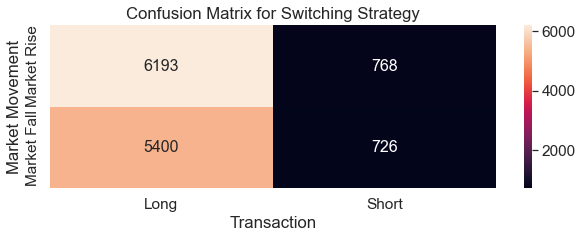

In [31]:
array = [[len(PM_long_earn),len(PM_long_loss)],[len(PM_short_loss),len(PM_short_earn)]]

df_cm = pd.DataFrame(array, ["Market Rise", "Market Fall"], ["Long", "Short"])
plt.figure(figsize=(10,3))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.title("Confusion Matrix for Switching Strategy")
plt.grid(visible = False)
plt.xlabel("Transaction")
plt.ylabel("Market Movement")
plt.show()
plt.show()
plt.show()

In [32]:
# B&H strategy predicts "768" more correct rising market movement. 
# How much more culmulative return it will earn?
from scipy.stats import gmean
gmean(abs(rise.loc[rise["predstate"] == 1][rise.loc[rise["predstate"] == 1].predstate_returns != 0].predstate_returns))

0.0035293367010734373

In [33]:
# Predicted Market Movement strategy predicts "726" more correct falling market movement. 
# How much more culmulative return it will earn?
from scipy.stats import gmean
gmean(PM_short_earn.predstate_returns)

0.0037747509356513857

## Step 2: Determine Decreasing Rates for each Predicted Market Movement
- There are two glidepaths: **original glidepath** & **glidepath based on predicted market movement**
- Adjust portfolio semi-anually.

In [34]:
# copy predicted market movement from step 1
df2 = test_pred_data[["predstate"]]
df2.tail()

,predstate
Date,
2021-11-11,0
2021-11-12,0
2021-11-15,0
2021-11-16,0
2021-11-17,0


In [35]:
# extract predicted market movement on the last days of June and Decemeber
df2 = df2.copy()

for i in range(1970,2021,1):
  date1 = str(i) + "/12/31"
  if(df2.index == pd.Timestamp(date1 +" 00:00:00")).any():
    #print(date1, " : ", df2.loc[date1, "predstate"])
    value = df2.loc[date1, "predstate"]
    df2.loc[str(i)+ "/1/1" : str(i+1)+ "/1/1", "predstate2"] = value
    continue
  date2 = str(i) + "/12/30"
  if(df2.index == pd.Timestamp(date2 +" 00:00:00")).any():
    #print(date2, " : ", df2.loc[date2, "predstate"])
    value = df2.loc[date2, "predstate"]
    df2.loc[str(i)+ "/1/1" : str(i+1)+ "/1/1", "predstate2"] = value
    continue
  date3 = str(i) + "/12/29"
  if(df2.index == pd.Timestamp(date3 +" 00:00:00")).any():
    #print(date3, " : ", df2.loc[date3, "predstate"])
    value = df2.loc[date3, "predstate"]
    df2.loc[str(i)+ "/1/1" : str(i+1)+ "/1/1", "predstate2"] = value
    continue

df2 = df2.copy()
for i in range(1970,2021,1):
  date1 = str(i) + "/6/30"
  if(df2.index == pd.Timestamp(date1 +" 00:00:00")).any():
    #print(date1, " : ", df2.loc[date1, "predstate"])
    value = df2.loc[date1, "predstate"]
    df2.loc[str(i)+ "/1/1" : str(i+1)+ "/6/30", "predstate2"] = value
    continue
  date2 = str(i) + "/6/29"
  if(df2.index == pd.Timestamp(date2 +" 00:00:00")).any():
    #print(date2, " : ", df2.loc[date2, "predstate"])
    value = df2.loc[date2, "predstate"]
    df2.loc[str(i)+ "/1/1" : str(i+1)+ "/6/29", "predstate2"] = value
    continue
  date3 = str(i) + "/6/28"
  if(df2.index == pd.Timestamp(date3 +" 00:00:00")).any():
    #print(date3, " : ", df2.loc[date3, "predstate"])
    value = df2.loc[date3, "predstate"]
    df2.loc[str(i)+ "/1/1" : str(i+1)+ "/6/28", "predstate2"] = value
    continue

<AxesSubplot:xlabel='Date'>

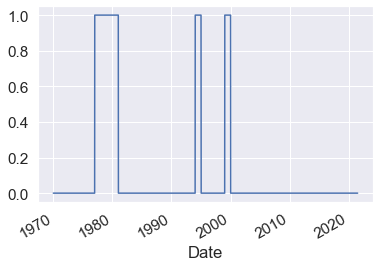

In [36]:
df2.predstate2.plot()

## 2.1 Prepare Data for Backtesting 
- S&P 500 index: 1970 - 2020
- Fidelity Investment Grade Bond Fund: 1980 - 2020

In [37]:
# S&P 500 index
ticker = "^GSPC"
start_date = '1969-12-31'
end_date = '2022-1-1'

sp500 = yf.download(ticker, start=start_date, end=end_date)
sp500['sp500_Return'] = sp500['Adj Close'].shift(-1) / sp500['Adj Close'] - 1
sp500.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,sp500_Return
Date,,,,,,,
1969-12-31,0.0,92.940002,91.150002,92.059998,92.059998,19380000,0.010211
1970-01-02,0.0,93.540001,91.790001,93.000000,93.000000,8050000,0.004946
1970-01-05,0.0,94.250000,92.529999,93.459999,93.459999,11490000,-0.006848
1970-01-06,0.0,93.809998,92.129997,92.820000,92.820000,11460000,-0.002047
1970-01-07,0.0,93.379997,91.930000,92.629997,92.629997,10010000,0.000540


In [38]:
# Fidelity Investment Grade Bond Fund
ticker = "FBNDX"
start_date = '1969-12-31'
end_date = '2022-1-1'

bond = yf.download(ticker, start=start_date, end=end_date)
bond['FBNDX_Return'] = bond['Adj Close'].shift(-1) / bond['Adj Close'] - 1
bond.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,FBNDX_Return
Date,,,,,,,
1980-01-02,7.38,7.38,7.38,7.38,0.494436,0,-0.004066
1980-01-03,7.35,7.35,7.35,7.35,0.492425,0,0.000000
1980-01-04,7.35,7.35,7.35,7.35,0.492425,0,0.000000
1980-01-07,7.35,7.35,7.35,7.35,0.492425,0,0.001361
1980-01-08,7.36,7.36,7.36,7.36,0.493096,0,0.000000


In [39]:
# Concatenate predicted states, S&P 500 index and Fidelity Investment Grade Bond Fund
df3 = pd.concat([df2[['predstate2']],sp500['sp500_Return'], bond['FBNDX_Return']],axis=1,sort='False')
df3 = df3["1970/1/1":"2021/1/1"]
df3.tail()

/var/folders/h4/gx6fy86160sbkwvpp0lwtj380000gn/T/ipykernel_20170/3463031468.py:2: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  df3 = pd.concat([df2[['predstate2']],sp500['sp500_Return'], bond['FBNDX_Return']],axis=1,sort='False')


,predstate2,sp500_Return,FBNDX_Return
Date,,,
2020-12-24,0.0,0.008723,0.000000
2020-12-28,0.0,-0.002227,0.001168
2020-12-29,0.0,0.001342,0.000000
2020-12-30,0.0,0.006439,0.002453
2020-12-31,0.0,-0.014755,-0.001165


## 2.2 Plot Original GlidePath and Calculate Corresponding Returns

<AxesSubplot:xlabel='Date'>

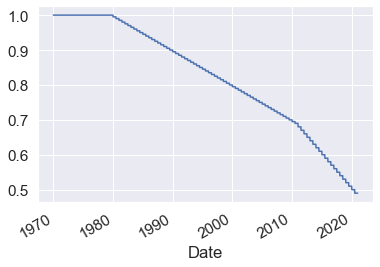

In [40]:
# plot original glidepath
df3['glidepath'] = 0
df3.loc["1970/1/1":"1980/12/31", "glidepath"] = 1
equity = 1

decrease_1 = 0.005
for i in range(1980,2011,1):
  equity = equity - decrease_1
  df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "glidepath"] = equity
  equity = equity - decrease_1
  df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "glidepath"] = equity

decrease_2 = 0.01
for j in range(2011,2021,1):
  equity = equity - decrease_2
  df3.loc[str(j)+ "/1/1" : str(j)+ "/7/1", "glidepath"] = equity
  equity = equity - decrease_2
  df3.loc[str(j)+ "/7/1" : str(j+1)+ "/1/1", "glidepath"] = equity

df3['glidepath'] = round(df3['glidepath'], 3)
df3.glidepath.plot()

In [41]:
# Calculate portfolio return of original glidepath for each day
df3['port_Return'] = 0
df3.loc["1970/1/1":"1981/1/1", "port_Return"] = 1 * df3.loc["1970/1/1":"1981/1/1", "sp500_Return"]
df3.loc["1981/1/1":, "port_Return"] = (df3.loc["1981/1/1":, "glidepath"] * df3.loc["1981/1/1":, "sp500_Return"]) + (( 1-df3.loc["1981/1/1":, "glidepath"]) * df3.loc["1981/1/1":, "FBNDX_Return"]) 
df3.head()

,predstate2,sp500_Return,FBNDX_Return,glidepath,port_Return
Date,,,,,
1970-01-02,0.0,0.004946,NaN,1.0,0.004946
1970-01-05,0.0,-0.006848,NaN,1.0,-0.006848
1970-01-06,0.0,-0.002047,NaN,1.0,-0.002047
1970-01-07,0.0,0.000540,NaN,1.0,0.000540
1970-01-08,0.0,-0.003021,NaN,1.0,-0.003021


## 2.3 Find the appropraite set of decreasing ratios for New Glidepath

In [42]:
# create function to test each set of decreasing ratios
# Input: dataframe, decreasing ratio 1 (for state 0) and decreasing ratio 2 (for state 1)
# Output: equity percentage on last day, culmulative return on last day
def test(df3, decrease_11_, decrease22_):
  df3["new_glidepath"] = 0

  df3.loc["1970/1/1":"1980/12/31", "new_glidepath"] = 1

  decrease_11 = decrease_11_
  decrease_22 = decrease22_
  new_equity = 1

  for i in range(1980,2021,1):
    date = str(i) + "/6/30"
    if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
      if(df3.loc[date, "predstate2"] == 0):
        new_equity = new_equity - decrease_11
        df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
        ###
        date = str(i) + "/12/31"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/30"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/29"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        ###
      elif(df3.loc[date, "predstate2"] == 1):
        new_equity = new_equity - decrease_22
        df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
        ###
        date = str(i) + "/12/31"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/30"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/29"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue



    date = str(i) + "/6/29"
    if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
      if(df3.loc[date, "predstate2"] == 0):
        new_equity = new_equity - decrease_11
        df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
        ###
        date = str(i) + "/12/31"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/30"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/29"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        ###
      elif(df3.loc[date, "predstate2"] == 1):
        new_equity = new_equity - decrease_22
        df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
        ###
        date = str(i) + "/12/31"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/30"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/29"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
            ###
    date = str(i) + "/6/28"
    if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
      if(df3.loc[date, "predstate2"] == 0):
        new_equity = new_equity - decrease_11
        df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
        ###
        date = str(i) + "/12/31"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/30"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/29"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
      ###
      elif(df3.loc[date, "predstate2"] == 1):
        new_equity = new_equity - decrease_22
        df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
        date = str(i) + "/12/31"
        ###
        date = str(i) + "/12/31"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/30"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        date = str(i) + "/12/29"
        if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
          if(df3.loc[date, "predstate2"] == 0):
            new_equity = new_equity - decrease_11
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
          elif(df3.loc[date, "predstate2"] == 1):
            new_equity = new_equity - decrease_22
            df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
            continue
        ###
  df3['new_port_Return'] = 0
  df3.loc["1970/1/1":"1981/1/1", "new_port_Return"] = 1 * df3.loc["1970/1/1":"1981/1/1", "sp500_Return"]
  df3.loc["1981/1/1":, "new_port_Return"] = (df3.loc["1981/1/1":, "new_glidepath"] * df3.loc["1981/1/1":, "sp500_Return"]) + (( 1-df3.loc["1981/1/1":, "new_glidepath"]) * df3.loc["1981/1/1":, "FBNDX_Return"]) 
  #print("d1: ", decrease_11_, ", d2: ", decrease22_)
  if(df3.new_glidepath[-1] < 0.51 and df3.new_glidepath[-1] > 0.49):
    print("d1: ", decrease_11_, ", d2: ", decrease22_, ", last equity: ", df3.new_glidepath[-1], ", cumret: ", (df3.new_port_Return+1).cumprod()[-1])
  return [df3.new_glidepath[-1], (df3.new_port_Return+1).cumprod()[-1]]

In [43]:
d1 = []
d2 = []
last_equity = []
last_culret = []

for i in np.arange(0.00125 , 0.0175, 0.00025):
    for j in np.arange(0.00125, i, 0.00025):
        output = test(df3, j, i)
        d1.append(j)
        d2.append(i)
        last_equity.append(output[0])
        last_culret.append(output[1])

d1:  0.006 , d2:  0.00625 , last equity:  0.5064999999999997 , cumret:  35.918728079782106
d1:  0.006 , d2:  0.006500000000000001 , last equity:  0.5049999999999999 , cumret:  35.907722398472394
d1:  0.006 , d2:  0.00675 , last equity:  0.5034999999999994 , cumret:  35.89663619029887
d1:  0.006 , d2:  0.007 , last equity:  0.5019999999999996 , cumret:  35.88546953310673
d1:  0.006 , d2:  0.00725 , last equity:  0.5004999999999997 , cumret:  35.874222505278105
d1:  0.006 , d2:  0.007500000000000001 , last equity:  0.4989999999999999 , cumret:  35.86289518573142
d1:  0.006 , d2:  0.007750000000000001 , last equity:  0.4974999999999994 , cumret:  35.85148765391857
d1:  0.006 , d2:  0.008 , last equity:  0.49599999999999955 , cumret:  35.839999989824754
d1:  0.006 , d2:  0.00825 , last equity:  0.4944999999999997 , cumret:  35.828432273970435
d1:  0.006 , d2:  0.0085 , last equity:  0.4929999999999999 , cumret:  35.81678458740425
d1:  0.006 , d2:  0.008749999999999999 , last equity:  0.491

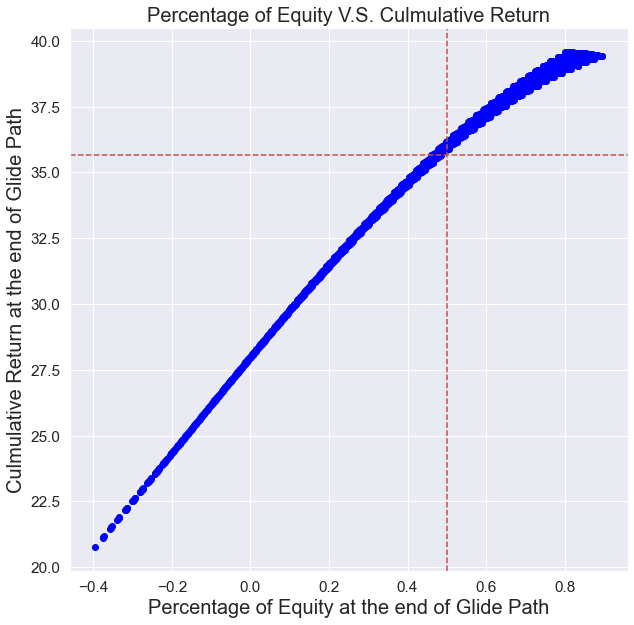

In [44]:
# Visualization : last_quity_percentage & last_culmulative_return
plt.figure(figsize=(10, 10))
plt.scatter(last_equity, last_culret, c ="blue")

plt.title('Percentage of Equity V.S. Culmulative Return', fontsize = 20)
plt.ylabel('Culmulative Return at the end of Glide Path', fontsize = 20)
plt.xlabel('Percentage of Equity at the end of Glide Path', fontsize = 20)
plt.axhline(35.66, color='r', linestyle = '--')
plt.axvline(0.5, color='r', linestyle = '--')
plt.grid(visible= True)
plt.show()

Text(0.5, 0, 'Percentage of Equity at the end of glide path')

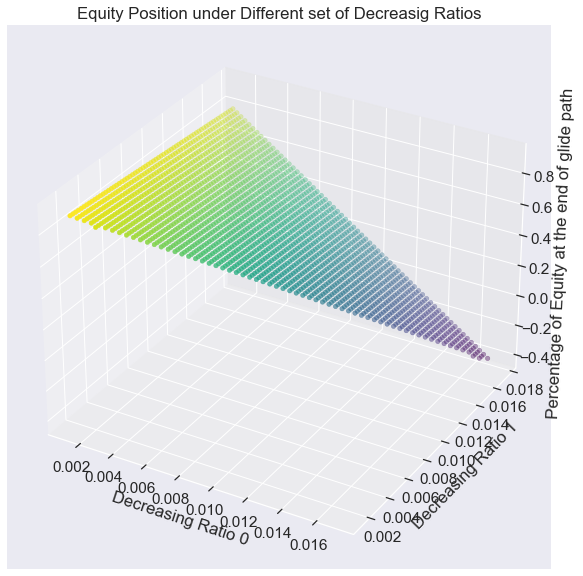

In [45]:
# Visualization : decreasing rate 1, decreasing rate 2, last_quity_percentage
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
ax.scatter(d1, d2, last_equity, c=last_equity, cmap='viridis', linewidth=0.5)
plt.title('Equity Position under Different set of Decreasig Ratios')

ax.set_xlabel("Decreasing Ratio 0")
ax.set_ylabel("Decreasing Ratio 1")
ax.set_zlabel("Percentage of Equity at the end of glide path")

Text(0.5, 0, 'Culmulative Return')

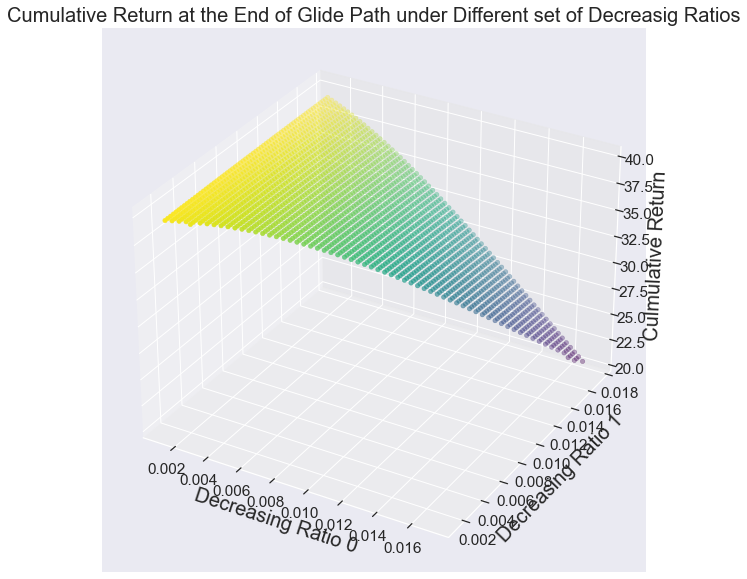

In [46]:
# Visualization : decreasing rate 1, decreasing rate 2, last_culmulative_return
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(d1, d2, last_culret, c=last_culret, cmap='viridis', linewidth=0.5)
plt.title('Cumulative Return at the End of Glide Path under Different set of Decreasig Ratios', fontsize = 20)

ax.set_xlabel("Decreasing Ratio 0", fontsize = 20)
ax.set_ylabel("Decreasing Ratio 1", fontsize = 20)
ax.set_zlabel("Culmulative Return", fontsize = 20)

## 2.4 Plot New GlidePath and Calculate Corresponding Returns

In [47]:
# Calculate percentage of equity every day
df3["new_glidepath"] = 0

df3.loc["1970/1/1":"1980/12/31", "new_glidepath"] = 1

decrease_11 = 0.00550
decrease_22 = 0.01225
new_equity = 1

for i in range(1980,2021,1):
  date = str(i) + "/6/30"
  if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
    if(df3.loc[date, "predstate2"] == 0):
      new_equity = new_equity - decrease_11
      df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
      ###
      date = str(i) + "/12/31"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/30"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/29"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      ###
    elif(df3.loc[date, "predstate2"] == 1):
      new_equity = new_equity - decrease_22
      df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
      ###
      date = str(i) + "/12/31"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/30"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/29"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue



  date = str(i) + "/6/29"
  if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
    if(df3.loc[date, "predstate2"] == 0):
      new_equity = new_equity - decrease_11
      df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
      ###
      date = str(i) + "/12/31"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/30"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/29"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      ###
    elif(df3.loc[date, "predstate2"] == 1):
      new_equity = new_equity - decrease_22
      df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
      ###
      date = str(i) + "/12/31"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/30"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/29"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
          ###
  date = str(i) + "/6/28"
  if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
    if(df3.loc[date, "predstate2"] == 0):
      new_equity = new_equity - decrease_11
      df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
      ###
      date = str(i) + "/12/31"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/30"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/29"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
    ###
    elif(df3.loc[date, "predstate2"] == 1):
      new_equity = new_equity - decrease_22
      df3.loc[str(i)+ "/1/1" : str(i)+ "/7/1", "new_glidepath"] = new_equity
      date = str(i) + "/12/31"
      ###
      date = str(i) + "/12/31"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/30"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      date = str(i) + "/12/29"
      if(df3.index == pd.Timestamp(date +" 00:00:00")).any():
        if(df3.loc[date, "predstate2"] == 0):
          new_equity = new_equity - decrease_11
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
        elif(df3.loc[date, "predstate2"] == 1):
          new_equity = new_equity - decrease_22
          df3.loc[str(i)+ "/7/1" : str(i+1)+ "/1/1", "new_glidepath"] = new_equity
          continue
      ###
df3['new_glidepath'] = round(df3['new_glidepath'], 5)
df3.tail()

,predstate2,sp500_Return,FBNDX_Return,glidepath,port_Return,new_glidepath,new_port_Return
Date,,,,,,,
2020-12-24,0.0,0.008723,0.000000,0.49,0.004274,0.5085,-0.003450
2020-12-28,0.0,-0.002227,0.001168,0.49,-0.000496,0.5085,0.002511
2020-12-29,0.0,0.001342,0.000000,0.49,0.000657,0.5085,-0.000531
2020-12-30,0.0,0.006439,0.002453,0.49,0.004406,0.5085,0.000877
2020-12-31,0.0,-0.014755,-0.001165,0.49,-0.007824,0.5085,0.004209


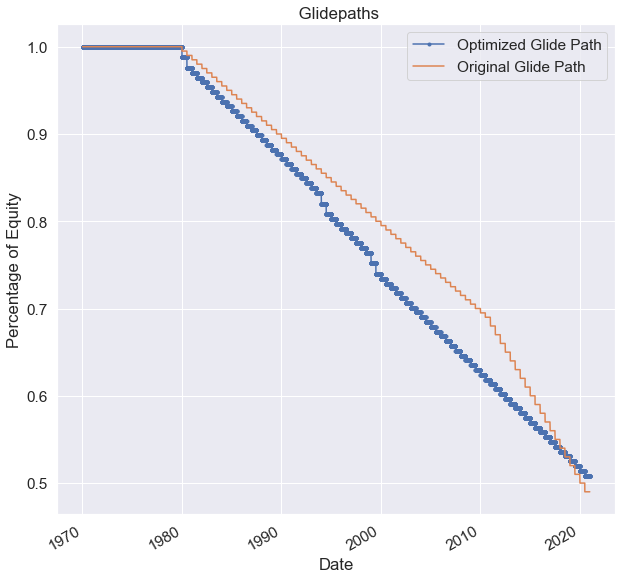

In [48]:
#Visualization: Original and new Glide Path
plt.figure(figsize=(10, 10))

df3.new_glidepath.plot(marker = '.')
df3.glidepath.plot()

plt.title(' Glidepaths')
plt.ylabel('Percentage of Equity')
plt.legend(labels=['Optimized Glide Path','Original Glide Path'])
plt.grid(visible= True)
plt.show()

In [49]:
# Caculate portfolio return for new glide path and cumulative returns for original and new glide paths
df3['new_port_Return'] = 0
df3.loc["1970/1/1":"1981/1/1", "new_port_Return"] = 1 * df3.loc["1970/1/1":"1981/1/1", "sp500_Return"]
df3.loc["1981/1/1":, "new_port_Return"] = (df3.loc["1981/1/1":, "new_glidepath"] * df3.loc["1981/1/1":, "sp500_Return"]) + (( 1-df3.loc["1981/1/1":, "new_glidepath"]) * df3.loc["1981/1/1":, "FBNDX_Return"]) 

df3['asset_value'] = (df3.port_Return+1).cumprod()
df3['new_asset_value'] = (df3.new_port_Return+1).cumprod()

df3.head()

,predstate2,sp500_Return,FBNDX_Return,glidepath,port_Return,new_glidepath,new_port_Return,asset_value,new_asset_value
Date,,,,,,,,,
1970-01-02,0.0,0.004946,NaN,1.0,0.004946,1.0,0.004946,1.004946,1.004946
1970-01-05,0.0,-0.006848,NaN,1.0,-0.006848,1.0,-0.006848,0.998065,0.998065
1970-01-06,0.0,-0.002047,NaN,1.0,-0.002047,1.0,-0.002047,0.996021,0.996021
1970-01-07,0.0,0.000540,NaN,1.0,0.000540,1.0,0.000540,0.996559,0.996559
1970-01-08,0.0,-0.003021,NaN,1.0,-0.003021,1.0,-0.003021,0.993548,0.993548


## 2.5 Compare the performance of two Glide Paths

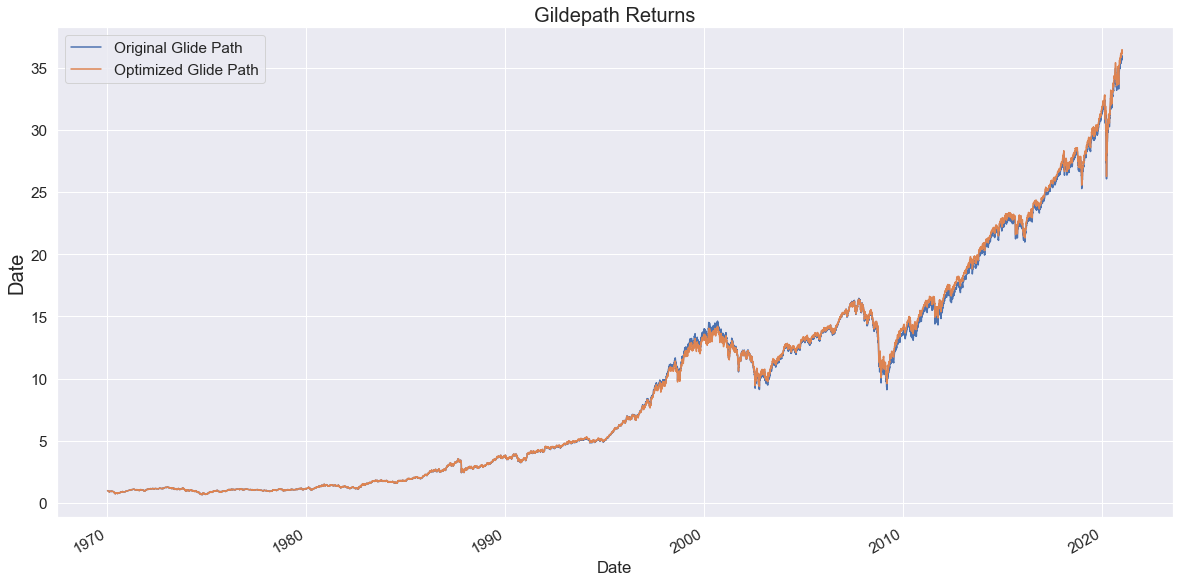

In [50]:
# Set the figure size
plt.figure(figsize=(20, 10))

# Retrun with original glidepath
df3.asset_value.plot()

# Retrun with new glidepath
df3.new_asset_value.plot()
    
# Set the title, label and grid
plt.title('Gildepath Returns', fontsize = 20)
plt.ylabel('Cumulative Returns', fontsize = 20)
plt.ylabel('Date', fontsize = 20)
plt.legend(labels=['Original Glide Path','Optimized Glide Path'])
plt.grid(visible= True)
plt.show()

In [51]:
# Hoy many percentages of time new glidepath outperforming original glidepath?

low = sum(df3.new_asset_value < df3.asset_value)
high = sum(df3.new_asset_value >= df3.asset_value)
 
print( high / (low + high)*100, "% of time new glidepath outperforming original glidepath")

85.76869267837712 % of time new glidepath outperforming original glidepath


In [52]:
## Culmulative Return

print("Culmulative Return of ORIGNIAL GLIDEPATH", df3.asset_value[-1])
print("Culmulative Return of NEW GLIDEPATH", df3.new_asset_value[-1])

Culmulative Return of ORIGNIAL GLIDEPATH 35.669964343833264
Culmulative Return of NEW GLIDEPATH 36.14656671556972


In [53]:
## Sharpe Ratio

def std_dev(data):
    # Get number of observations
    n = len(data)
    # Calculate mean
    mean = sum(data) / n
    # Calculate deviations from the mean
    deviations = sum([(x - mean)**2 for x in data])
    # Calculate Variance & Standard Deviation
    variance = deviations / (n - 1)
    s = variance**(1/2)
    return s

# Sharpe Ratio From Scratch
def sharpe_ratio(data, risk_free_rate=0.0):
    # Calculate Average Daily Return
    mean_daily_return = sum(data) / len(data)
    # Calculate Standard Deviation
    s = std_dev(data)
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    # Annualize Daily Sharpe Ratio
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    
    return sharpe_ratio

print("Sharpe Ratio of ORIGINAL Glidepath: ", sharpe_ratio(df3.port_Return))
print("Sharpe Ratio of NEW Glidepath: ", sharpe_ratio(df3.new_port_Return))

Sharpe Ratio of ORIGINAL Glidepath:  0.5776738804120704
Sharpe Ratio of NEW Glidepath:  0.5982595461282305


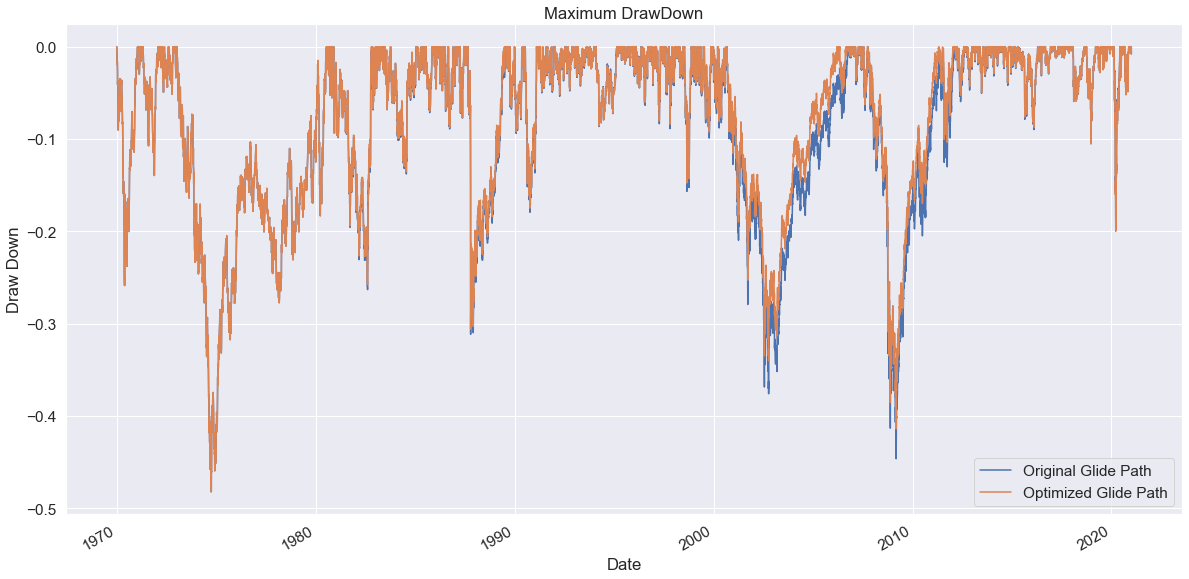

In [54]:
### Maximum drawdown


plt.figure(figsize=(20, 10))
window = 252*40

# Calculate the max drawdown in the past window days for each day in the series.
Roll_Max = df3['asset_value'].rolling(window, min_periods=1).max()
Daily_Drawdown = df3['asset_value']/Roll_Max - 1.0

new_Roll_Max = df3['new_asset_value'].rolling(window, min_periods=1).max()
new_Daily_Drawdown = df3['new_asset_value']/new_Roll_Max - 1.0

# Plot the results
Daily_Drawdown.plot()
new_Daily_Drawdown.plot()

plt.title('Maximum DrawDown')
plt.ylabel('Draw Down')
plt.legend(labels=['Original Glide Path','Optimized Glide Path'])
plt.grid(visible= True)
plt.show()